##  Digital Quantum Simulations of Time Evolution - Simulating the Dicke Model
---
### Modules and some comments
Take a look at the file `classical_evolution` in the folder `tools`.

In [27]:
# Ignore: things to make plots pretty on my computer 
from pkg_resources import working_set

if 'jupyterthemes' in ["%s" % package.key for package in working_set]:
    from jupyterthemes import jtplot
    jtplot.style(theme = 'monokai', context = 'notebook', ticks = True, grid = True)

In [28]:
# Important: the functions below are defined in the files `classical_evolution` and 
# `quantum_evolution` in the folder `tools`
from tools.classical_evolution import dicke_hamiltonian, state_probability, define_state
from tools.quantum_evolution import get_circuit, trotter_circuit, define_operator

In [29]:
# Usual suspects
from numpy import linspace, pi, zeros_like, zeros, ones
from qiskit import Aer
from qiskit.opflow import CircuitSampler, StateFn, I, Z
from qiskit.opflow.expectations import PauliExpectation
from matplotlib.pyplot import plot, xlabel, ylabel, title, grid, show, legend, ylim

### Classical simulation
It is already generalizable to $N>2$ and, hoping that it is more or less correct, you can already try to see what happens by changing the `spins` variable.

In [30]:
# Checking if the hamiltonian is correct
spins = 2 # Number of 2-level systems
coupling = 1
frequency = 1
hamiltonian = dicke_hamiltonian(spins = spins, frequency = frequency, coupling = coupling)
print(hamiltonian)

1.0 * IZ
+ 1.0 * ZI
- 2.0 * XX


In [31]:
# Classical simulation
times = linspace(0, pi, 200) # Time discretization
initial_state = define_state([0 for _ in range(spins)]) # Ground state: all spins down
state = define_state([1 for _ in range(spins)]) # All spins up
classical_probabilities = [state_probability(hamiltonian, time, initial_state, state) for time in times]

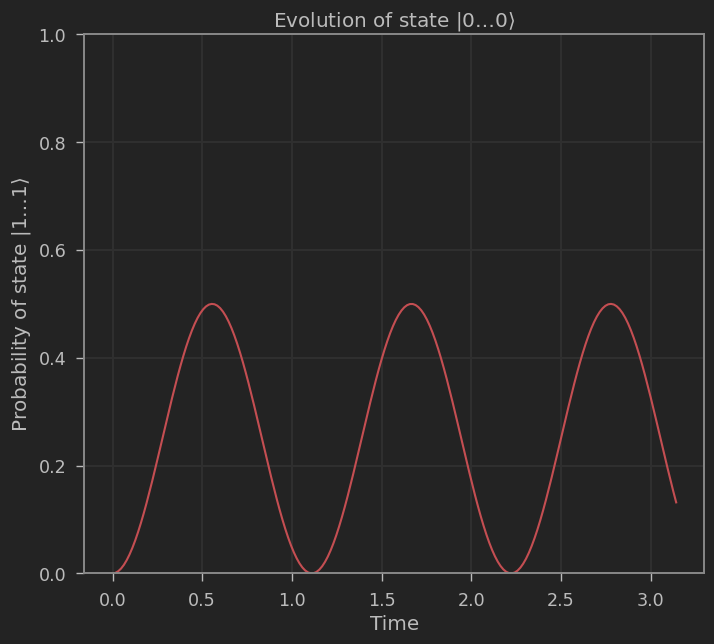

In [32]:
plot(times, classical_probabilities, '-r')
xlabel('Time')
ylim(0, 1)
ylabel(r'Probability of state $|1\dots1\rangle$')
title(r'Evolution of state $|0\dots0\rangle$')
show()

### Quantum simulation
First notice that:

$$H^{(2)}=\omega_z\left(\sigma_z^{(1)}+\sigma_z^{(2)}\right)-2g\sigma_x^{(1)}\sigma_x^{(2)}$$

now, we have that:

$$
\begin{cases}
\left[\sigma_z^{(1)}, \sigma_z^{(1)}\right]=0 \\
\left[\sigma_z^{(1)}, \sigma_x^{(1)}\sigma_x^{(2)}\right]=\left[\sigma_z^{(1)}, \sigma_x^{(1)}\right]\sigma_x^{(2)}=-2\mathcal{i}\sigma_y^{(1)}\sigma_x^{(2)} \\
\left[\sigma_z^{(2)}, \sigma_x^{(1)}\sigma_x^{(2)}\right]=\dots=-2\mathcal{i}\sigma_y^{(2)}\sigma_x^{(1)} \\
\end{cases}
$$

thus they do not commute even in this case, so we have to use the Trotter-Suzuki technique.

By the way, it should work with whatever number $N$, also for $N>2$.

**Question**: why we use the same $n$ for all the time instants in the implementation of the Trotter-Suzuki technique?

In [33]:
backend = Aer.get_backend("statevector_simulator")
expectation = PauliExpectation() 
sampler = CircuitSampler(backend)

In [34]:
steps = [4, 8, 12]
quantum_probabilities = {i : zeros_like(times) for i in steps}
operator = define_operator([1 for _ in range(spins)])

In [35]:
for steps in quantum_probabilities.keys():
    for i, time in enumerate(times):
        circuit = trotter_circuit(spins, time, steps, coupling)
        trotter_expectation = expectation.convert(operator @ StateFn(circuit))
        trotter_sample = sampler.convert(trotter_expectation)
        quantum_probabilities[steps][i] = trotter_sample.eval().real

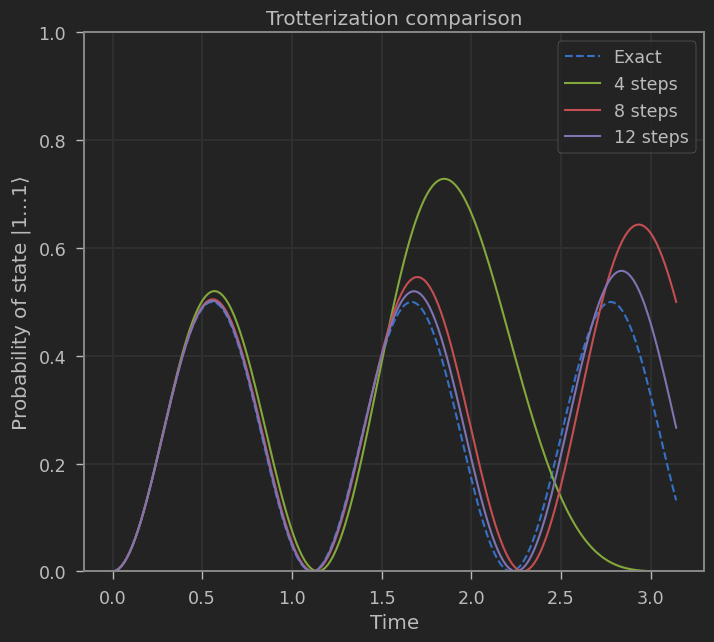

In [36]:
plot(times, classical_probabilities, '--', label = "Exact")

for steps in quantum_probabilities.keys():
    plot(times, quantum_probabilities[steps], label = str(steps) + " steps")

xlabel('Time')
ylabel(r'Probability of state $|1\dots1\rangle$')
title(r'Trotterization comparison')
ylim(0, 1)
legend()
show()

# Computing magnetization

In [37]:
from numpy import array, kron, abs, real, zeros
from scipy.linalg import expm
from itertools import combinations

In [38]:
# Classical simulation of the Heisenberg dimer model
ctime = linspace(0, pi, 1000)

# Preparation of physical quantity: writing the single qubit operators, that is the Pauli matrices
operator_i = array([[1, 0], [0, 1]], dtype = complex) 
operator_x = array([[0, 1], [1, 0]], dtype = complex) 
operator_z = array([[1, 0], [0, -1]], dtype = complex) 

In [39]:
def cross_product(list_z):
    product = kron(list_z[0], list_z[1])

    for operator in list_z[2:]:
        product = kron(product, operator)
        
    return product

In [40]:
list_z = [[operator_i if i != j else operator_z for i in range(spins)] for j in range(spins)]
H = cross_product(list_z[0])

for operator in list_z[1:]:
    H += frequency * cross_product(operator)

In [41]:
xx = []

for pair in combinations(range(spins), 2):
    a, b = pair
    xx += [[operator_i if i != a and i != b else operator_x for i in range(spins)]]

In [42]:
for operator in xx:
    H -= 2 * coupling * cross_product(operator)

In [43]:
# Initial state definition and execution
psio = zeros(2 ** spins, dtype = complex)
psio[0] = 1

In [44]:
magnetization = array([zeros_like(ctime) for _ in range(spins)])

In [45]:
for i, t in enumerate(ctime):
    psit = expm(-1j * H * t) @ psio
    
    for j in range(spins):
        magnetization[j][i] = real(psit.conjugate().transpose() @ \
                                   cross_product(list_z[j]) @ psit) / 2

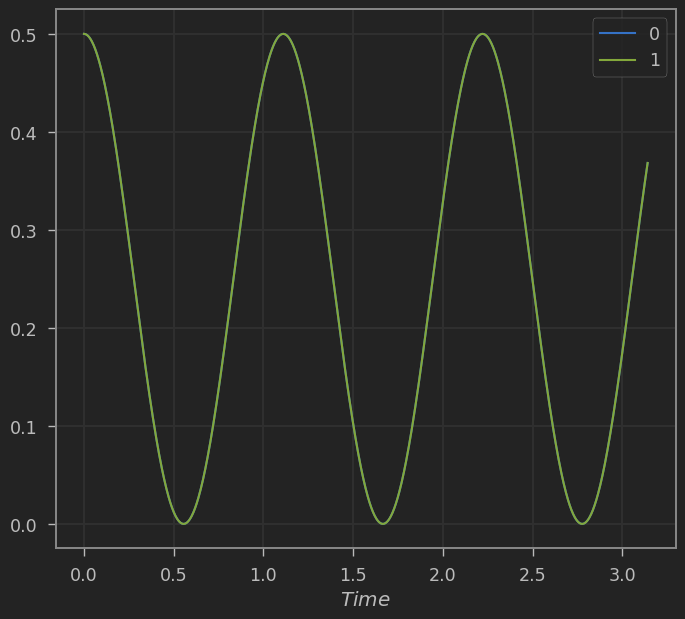

In [46]:
for i in range(spins):
    plot(ctime, magnetization[i], label = str(i))
    
legend()
xlabel(r'$Time$')
show()

In [47]:
from qiskit import BasicAer, transpile, execute
from qiskit.circuit import Parameter
from qiskit.providers.aer import QasmSimulator

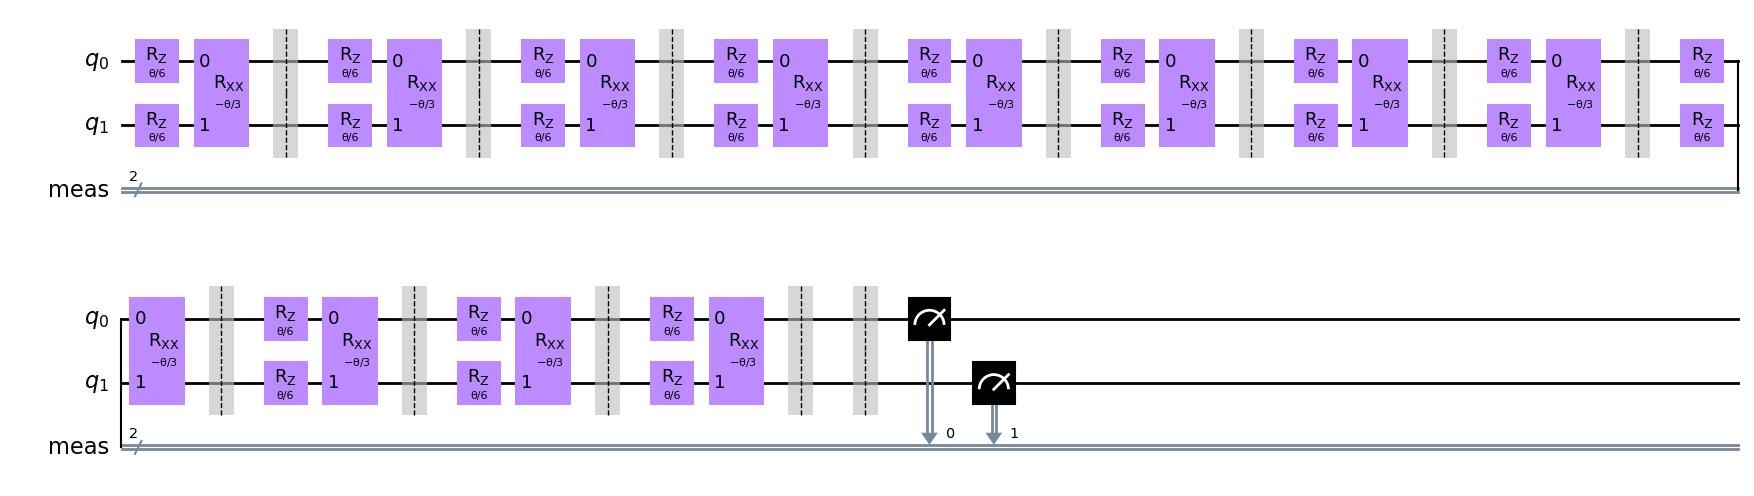

In [58]:
# Creating the parametrized circuit
qtime = linspace(0, pi, 50)
theta = Parameter('θ')
spins = 2
circuit = trotter_circuit(spins, theta, 12, coupling)
circuit.measure_all()
circuit.draw('mpl')

In [59]:
times = linspace(0, pi, 50)
shots = 1000
circuits = [circuit.bind_parameters({theta: time}) for time in qtime]

In [60]:
# Transpiling and simulating
backend = BasicAer.get_backend('qasm_simulator')
transpiled_circuits = transpile(circuits, backend)
job = backend.run(transpiled_circuits, shots = shots)
counts = job.result().get_counts()

In [61]:
%%time
zaq, zbq = zeros_like(qtime), zeros_like(qtime)

for i, count in enumerate(counts):
    a = b = count.get('00', 0) - count.get('11', 0)
    a += count.get('10', 0) - count.get('01', 0)
    b -= count.get('10', 0) - count.get('01', 0)

    zaq[i] = a / shots / 2
    zbq[i] = b / shots / 2

CPU times: user 247 µs, sys: 13 µs, total: 260 µs
Wall time: 269 µs


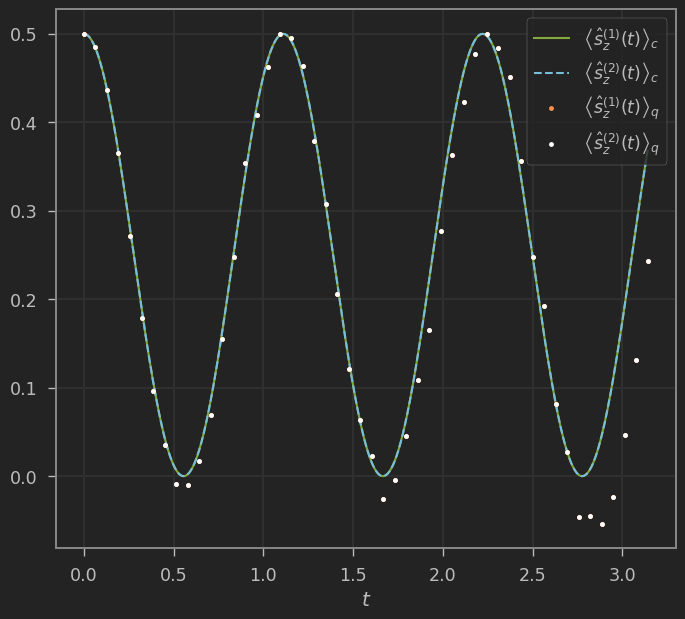

In [62]:
plot(ctime, magnetization[0], 'g-')
plot(ctime, magnetization[1], 'c--')
plot(qtime, zaq, 'y.')
plot(qtime, zbq, 'w.')
legend([r'$\left\langle\hat{s}^{(1)}_z(t)\right\rangle_c$',
        r'$\left\langle\hat{s}^{(2)}_z(t)\right\rangle_c$',
        r'$\left\langle\hat{s}^{(1)}_z(t)\right\rangle_q$',
        r'$\left\langle\hat{s}^{(2)}_z(t)\right\rangle_q$'])
xlabel(r'$t$')
show()